In [9]:
import ijson
import numpy as np
import json
from decimal import Decimal
import json
import time
import torch
import warnings
import pennylane as qml
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output

In [19]:
datos = []
def cargar_datos_json(json_path, num_jets=22500, num_constituents=10):
    with open(json_path, 'r') as f:
        data = json.load(f)

    eventos = []
    for i, evento in enumerate(data[:num_jets]):
        jet_pt, jet_eta, jet_phi, _ = evento['jet_kinematics']
        constituents = evento['PFCands']

        # Calcular pT para cada constituyente
        constituents = np.array(constituents)
        px = constituents[:, 0]
        py = constituents[:, 1]
        pt = np.sqrt(px**2 + py**2)

        # Índices de los 10 con mayor pT
        indices_ordenados = np.argsort(pt)[::-1][:num_constituents]
        top_cands = constituents[indices_ordenados]

        # Convertir cada uno a formato usado en el circuito
        top_constituents = []
        for cand in top_cands:
            px, py, pz, E = cand[0:4]
            pt = np.sqrt(px**2 + py**2)
            eta = 0.5 * np.log((E + pz) / (E - pz + 1e-8))  # evitar división por 0
            phi = np.arctan2(py, px)
            top_constituents.append({
                'pt': pt,
                'eta': eta,
                'phi': phi
            })

        eventos.append({
            'pt_jet': jet_pt,
            'eta_jet': jet_eta,
            'phi_jet': jet_phi,
            'constituents': top_constituents
        })

    return eventos

datos = cargar_datos_json('runG_batch0_reducido_22500.json')

In [20]:
print(len(datos))

22500


In [99]:
import json
import numpy as np

def cargar_datos_json(json_path, num_jets=10000, num_constituents=10):
    with open(json_path, 'r') as f:
        data = json.load(f)

    eventos = []
    for i, evento in enumerate(data[:num_jets]):
        # Extraer información del jet
        jet_pt = evento.get('jet_pt', i)
        jet_eta = evento.get('jet_eta', i)
        jet_phi = evento.get('jet_phi', i)
        
        # Extraer constituyentes (partículas)
        part_px = np.array(evento.get('part_px', []))
        part_py = np.array(evento.get('part_py', []))
        part_pz = np.array(evento.get('part_pz', []))
        part_energy = np.array(evento.get('part_energy', []))
        
        # Calcular pt, eta, phi para cada constituyente
        pt = np.sqrt(part_px**2 + part_py**2)
        p_total = np.sqrt(part_px**2 + part_py**2 + part_pz**2)
        theta = np.arccos(part_pz / (p_total + 1e-8))  # Evitar división por cero
        eta = -np.log(np.tan(theta / 2 + 1e-8))
        phi = np.arctan2(part_py, part_px)
        
        # Seleccionar los num_constituents con mayor pt
        indices_ordenados = np.argsort(pt)[::-1][:num_constituents]
        
        top_constituents = []
        for idx in indices_ordenados:
            top_constituents.append({
                'pt': pt[idx],
                'eta': eta[idx],
                'phi': phi[idx],
                'px': part_px[idx],
                'py': part_py[idx],
                'pz': part_pz[idx],
                'energy': part_energy[idx],
                'charge': evento['part_charge'][idx] if 'part_charge' in evento else 0
            })
            
        eventos.append({
            'pt_jet': jet_pt,
            'eta_jet': jet_eta,
            'phi_jet': jet_phi,
            'constituents': top_constituents
        })

    return eventos

# Ejemplo de uso
datos_HToBB = cargar_datos_json('HToBB_120.json', num_jets=10000, num_constituents=10)
datos_TTBar = cargar_datos_json('TTBar_120.json', num_jets=10000, num_constituents=10)
datos_WToqq = cargar_datos_json('WToQQ_120.json', num_jets=10000, num_constituents=10)
datos_QCD_simu = cargar_datos_json('ZJetsToNuNu_000.json', num_jets=10000, num_constituents=10)

In [21]:
from sklearn.model_selection import train_test_split

datos = np.array(datos)

# Separar 10,000 para entrenamiento y 12,500 restantes
X_train, X_temp = train_test_split(
    datos, 
    train_size=10000, 
    random_state=42, 
    shuffle=True
)

# Separar 2,500 para validación y 10,000 para inferencia
X_val, X_inf = train_test_split(
    X_temp, 
    train_size=2500, 
    random_state=42, 
    shuffle=True
)

# Verificar tamaños
print(f"Entrenamiento: {len(X_train)}")
print(f"Validación: {len(X_val)}")
print(f"Inferencia: {len(X_inf)}")

Entrenamiento: 10000
Validación: 2500
Inferencia: 10000


> ***“Each event is represented by a set of reconstructed jets ordered by decreasing transverse momentum (pT)…"***

Siguiendo con lo especificado en el paper....

\begin{align}
f \cdot \frac{p_T}{p_{T,\text{jet}}} \cdot (\eta - \eta_{\text{jet}}) \rightarrow \theta \tag{1} \\
f \cdot \frac{p_T}{p_{T,\text{jet}}} \cdot (\phi - \phi_{\text{jet}}) \rightarrow \varphi \tag{2} \\
(p_T, \eta, \phi) \rightarrow |\psi\rangle = R_X(\varphi)R_Y(\theta) |0\rangle \notag \\
= \alpha(\theta, \varphi) |0\rangle + \beta(\theta, \varphi) |0\rangle \tag{3} \\
f \rightarrow 1 + \frac{2\pi}{1+e^{-w}} \tag{4}
\end{align}


In [22]:
def f(w):
  return 1 + (2* np.pi / (1 + np.exp(-w)))

def phi_circuit(w, Phi, Phi_jet, Pt, Pt_jet):
  return f(w) * Pt / Pt_jet * (Phi - Phi_jet)

def theta_circuit(w, Theta, Theta_jet, Pt, Pt_jet):
  return f(w) * Pt / Pt_jet * (Theta - Theta_jet)


### ⚠️⚠️ **Funciones creadas únicamente para mostrar como se visualizarian los jets en la esfera de bloch** (para un ejemplo pasado de 10 eventos solo )
Puede ser útil para visualizar cosas y orientarnos un poco. En nombre de las variables esta desactualizado.

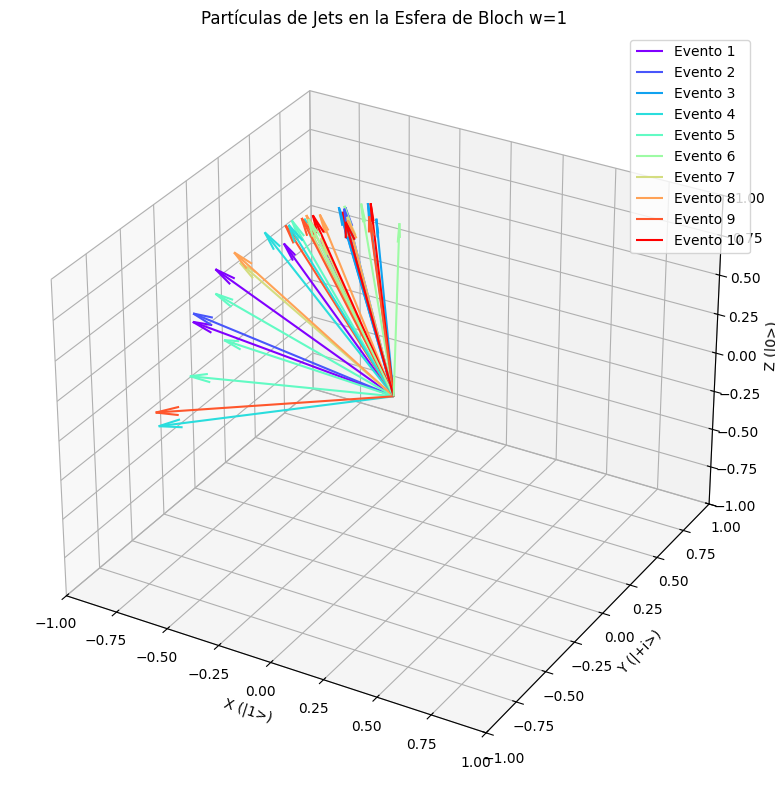

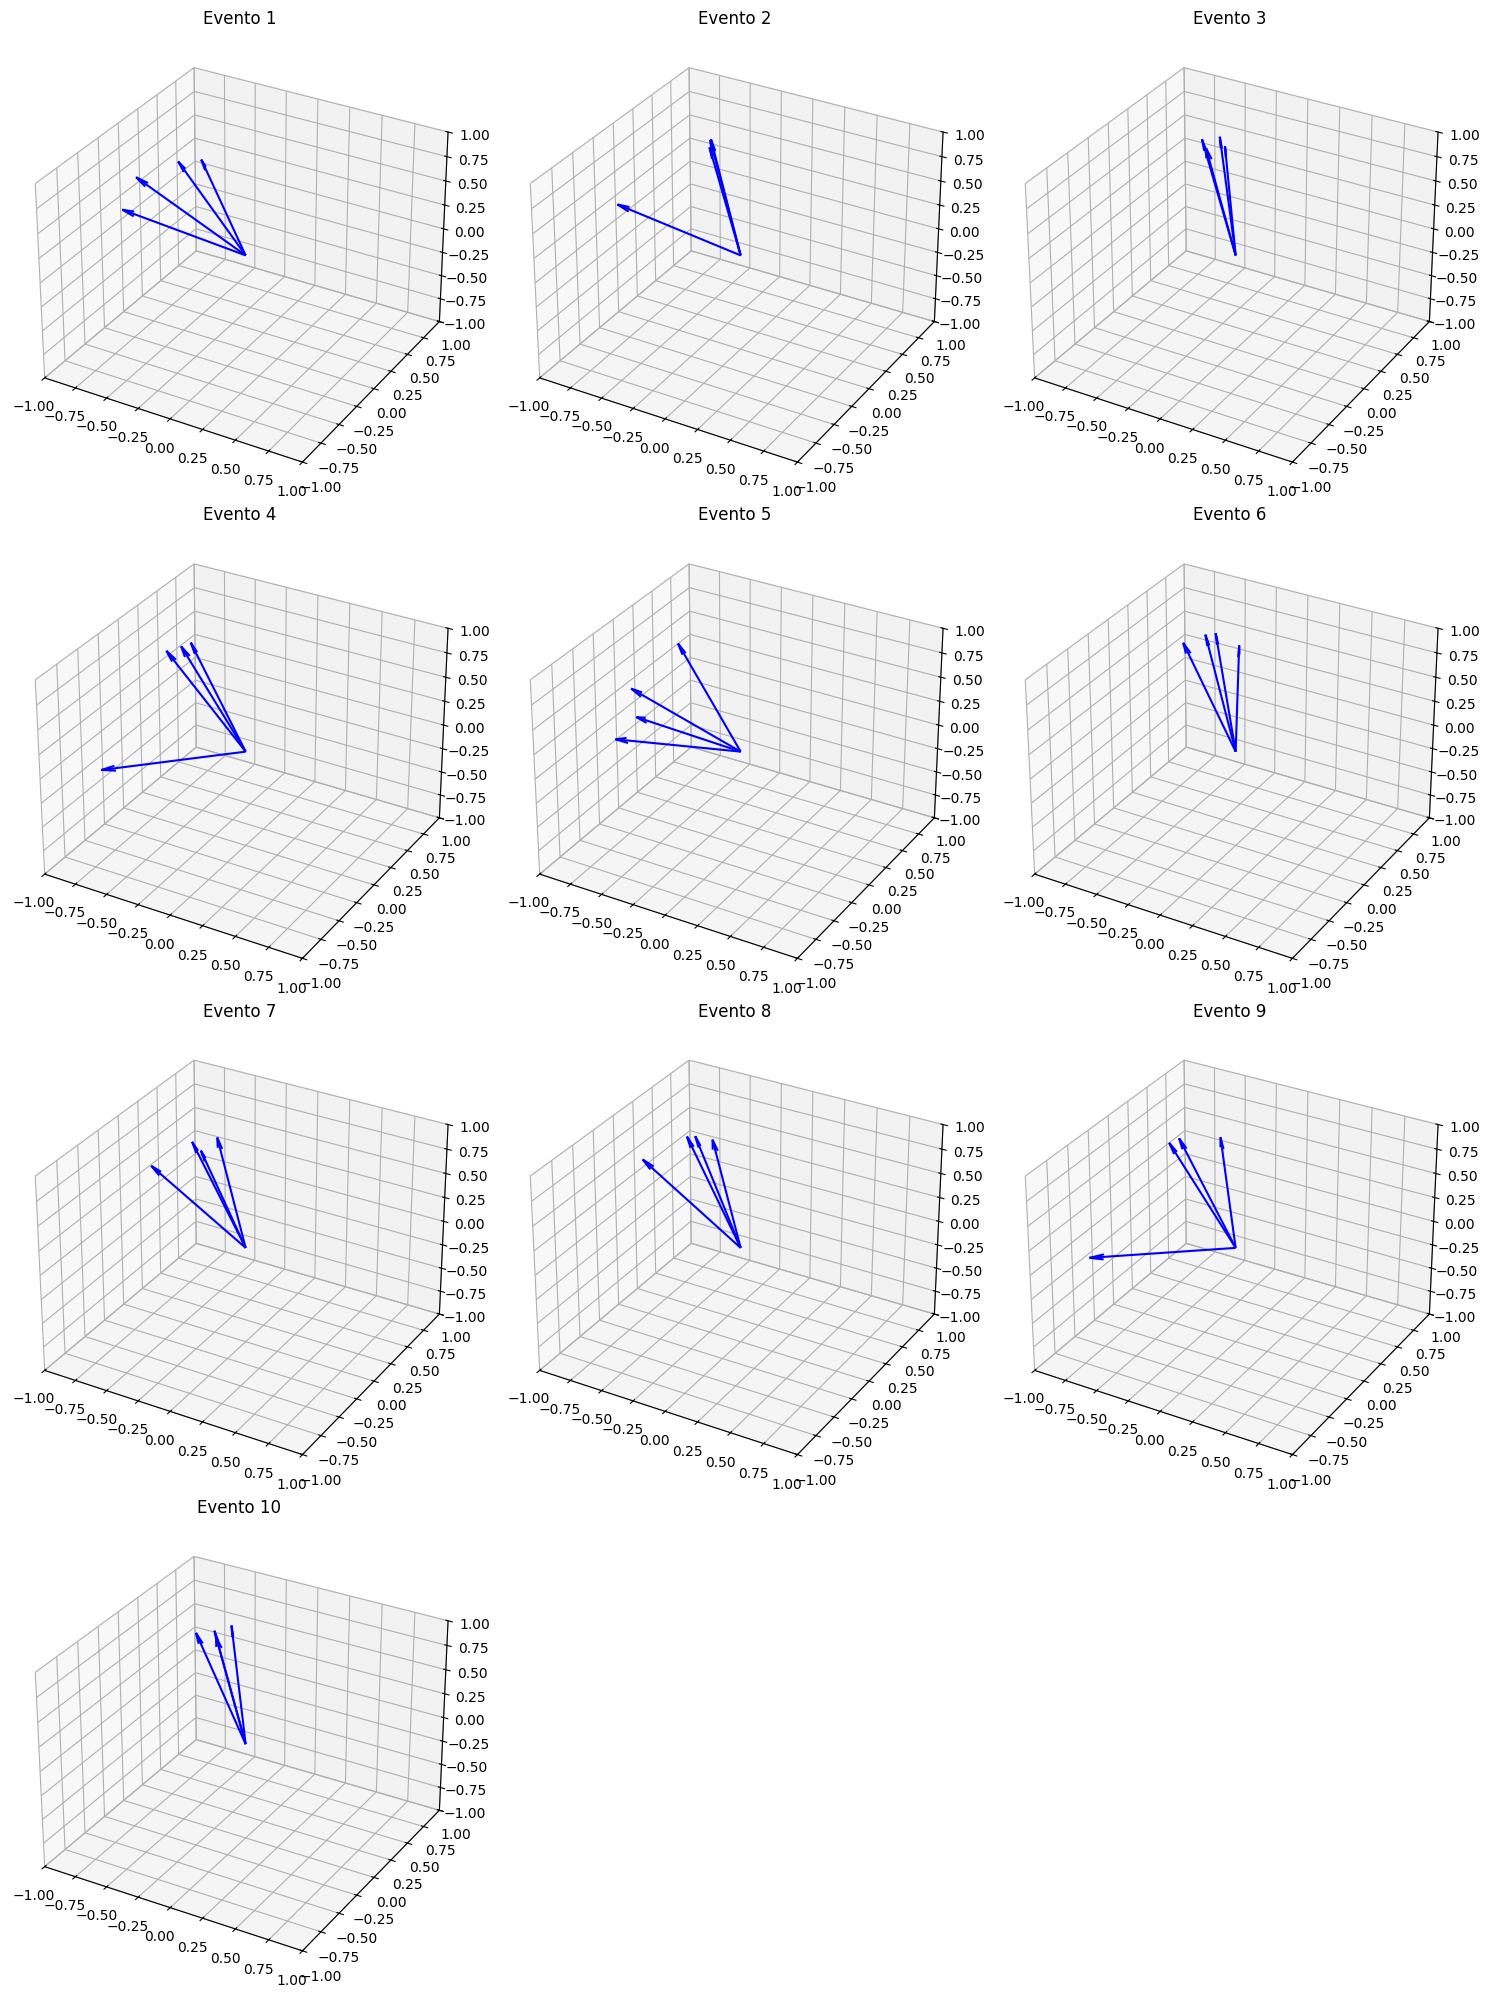

In [158]:
from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector
from qiskit.visualization import plot_bloch_multivector
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.cm as cm

def plot_jets_on_bloch(jets_data, num_particles=10):
    # Configurar colores distintos para cada jet
    colors = cm.rainbow(np.linspace(0, 1, len(jets_data)))

    # Crear figura 3D para la esfera de Bloch
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')

    for jet_idx, jet in enumerate(jets_data):
        if 'Jets' not in jet:
            continue

        # Tomar las primeras 'num_particles' partículas del jet
        particles = jet['Jets'][:num_particles]

        for part_idx, particle in enumerate(particles):
            # Calcular theta y phi según el esquema 1P1Q
            phi = phi_circuit(1, particle['phi'], phi_jet, particle['pt'], pt_jet)
            theta = theta_circuit(1, particle['eta'], eta_jet, particle['pt'], pt_jet)

            # Crear circuito cuántico para esta partícula
            qc = QuantumCircuit(1)
            qc.ry(theta, 0)
            qc.rx(phi, 0)

            # Obtener el estado cuántico
            state = Statevector.from_instruction(qc)
            bloch = state.data

            # Convertir a coordenadas cartesianas
            x = 2 * np.real(np.conj(bloch[0]) * bloch[1])
            y = 2 * np.imag(np.conj(bloch[0]) * bloch[1])
            z = abs(bloch[0])**2 - abs(bloch[1])**2

            # Graficar el vector con color específico para este jet
            ax.quiver(0, 0, 0, x, y, z,
                      color=colors[jet_idx],
                      arrow_length_ratio=0.1,
                      label=f'Evento {jet_idx+1}' if part_idx == 0 else "")

    # Configuración del gráfico
    ax.set_xlim([-1, 1])
    ax.set_ylim([-1, 1])
    ax.set_zlim([-1, 1])
    ax.set_xlabel('X (|1>)')
    ax.set_ylabel('Y (|+i>)')
    ax.set_zlabel('Z (|0>)')
    ax.set_title('Partículas de Jets en la Esfera de Bloch w=1')

    # Mostrar leyenda
    ax.legend()
    plt.tight_layout()
    plt.show()

# Función alternativa para mostrar cada jet en una esfera separada
def plot_jets_separate_bloch(jets_data, num_particles=10):
    num_jets = len(jets_data)
    cols = 3  # Número de columnas en el grid
    rows = (num_jets + cols - 1) // cols

    fig = plt.figure(figsize=(cols*5, rows*5))

    for jet_idx, jet in enumerate(jets_data):
        if 'Jets' not in jet:
            continue

        ax = fig.add_subplot(rows, cols, jet_idx+1, projection='3d')
        particles = jet['Jets'][:num_particles]

        for particle in particles:
            phi = phi_circuit(1, particle['phi'], phi_jet, particle['pt'], pt_jet)
            theta = theta_circuit(1, particle['eta'], eta_jet, particle['pt'], pt_jet)

            qc = QuantumCircuit(1)
            qc.ry(theta, 0)
            qc.rx(phi, 0)

            state = Statevector.from_instruction(qc)
            bloch = state.data

            x = 2 * np.real(np.conj(bloch[0]) * bloch[1])
            y = 2 * np.imag(np.conj(bloch[0]) * bloch[1])
            z = abs(bloch[0])**2 - abs(bloch[1])**2

            ax.quiver(0, 0, 0, x, y, z,
                      color='blue',
                      arrow_length_ratio=0.1)

        ax.set_xlim([-1, 1])
        ax.set_ylim([-1, 1])
        ax.set_zlim([-1, 1])
        ax.set_title(f'Evento {jet_idx+1}')

    plt.tight_layout()
    plt.show()

# Ejemplo de uso:
plot_jets_on_bloch(filtered_data_float_train[:10])  # Todos los jets en una esfera
plot_jets_separate_bloch(filtered_data_float_train[:10])  # Jets en esferas separadas

---
---
---
---

# **Código del paper**

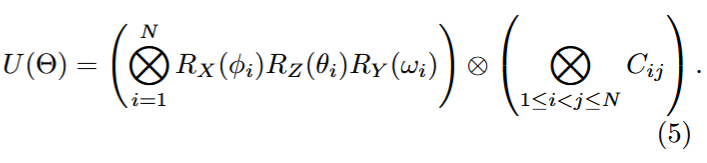

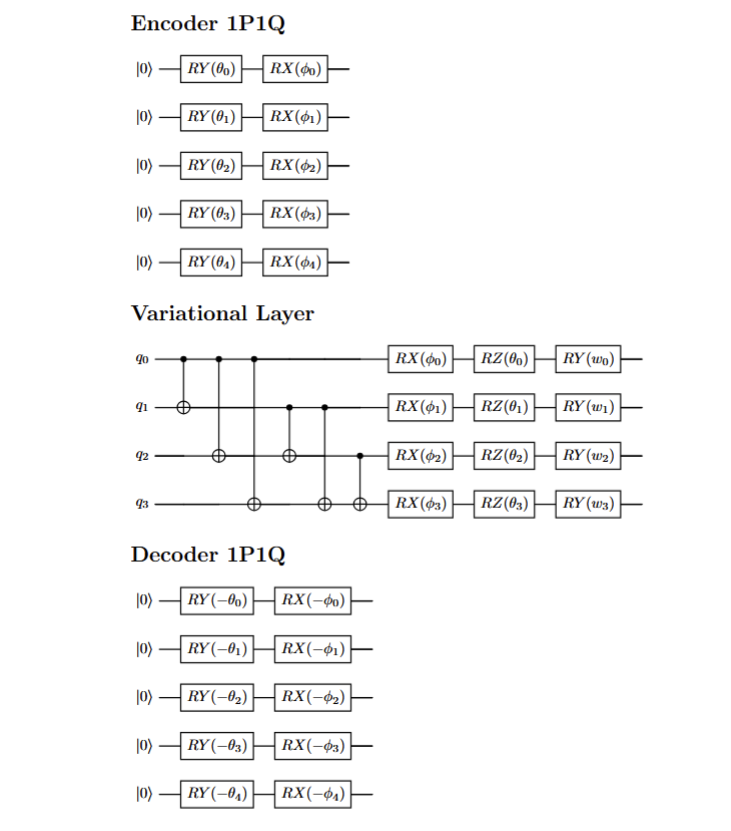

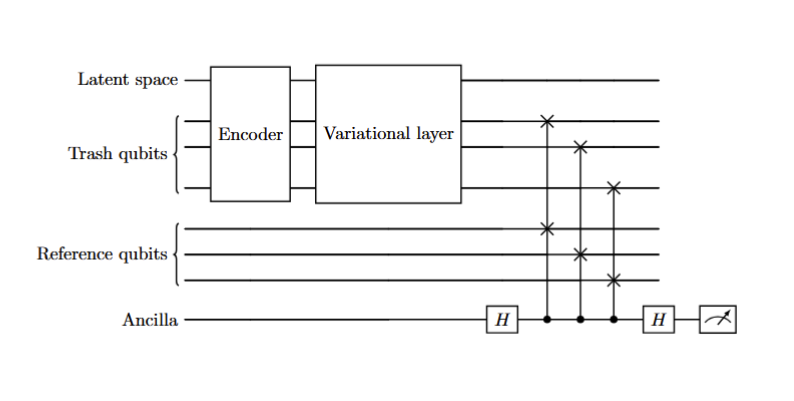

In [83]:
import pennylane as qml
import torch

# --- Parámetros del circuito ---
num_particles = 10
num_latent = 2
num_ref = num_particles - num_latent
num_trash = num_ref
wires = list(range(num_particles + num_ref + 1))  # +1 ancilla
ancilla = wires[-1]
dev = qml.device("default.qubit", wires=wires)

latent_wire = 0
trash_wires = wires[1:num_particles]
ref_wires = wires[num_particles:-1]


# --- Codificación 1P1Q (misma que en el paper) ---
def f(w):
    return 1 + (2 * np.pi / (1 + torch.exp(-w)))

def phi_circuit(w, phi, phi_jet, pt, pt_jet):
    return f(w) * pt / pt_jet * (phi - phi_jet)

def theta_circuit(w, eta, eta_jet, pt, pt_jet):
    return f(w) * pt / pt_jet * (eta - eta_jet)


# --- Encoder 1P1Q adaptado al nuevo formato de jet ---
def encode_1p1q(jet, w):
    pt_jet = jet['pt_jet']
    eta_jet = jet['eta_jet']
    phi_jet = jet['phi_jet']
    constituents = jet['constituents']

    for i in range(num_particles):
        c = constituents[i]
        theta = theta_circuit(w, c['eta'], eta_jet, c['pt'], pt_jet)
        phi = phi_circuit(w, c['phi'], phi_jet, c['pt'], pt_jet)
        qml.RY(theta, wires=i)
        qml.RX(phi, wires=i)


# --- Capa variacional ---
def variational_layer(theta_i, phi_i, w_i, num_layers):
    for layer in range(num_layers):
        for i in range(num_particles):
            for j in range(i + 1, num_particles):
                qml.CNOT(wires=[i, j])

        for i in range(num_particles):
            qml.RX(phi_i[layer, i], wires=i)
            qml.RZ(theta_i[layer, i], wires=i)
            qml.RY(w_i[layer, i], wires=i)


# --- QAE Circuit ---
@qml.qnode(dev, interface="torch", diff_method="backprop")
def qae_circuit(jet, w, theta_i, phi_i, w_i, num_layers):
    encode_1p1q(jet, w)
    variational_layer(theta_i, phi_i, w_i, num_layers)

    for trash_wire, ref_wire in zip(trash_wires, ref_wires):
        qml.Hadamard(wires=ancilla)
        qml.CSWAP(wires=[ancilla, trash_wire, ref_wire])
        qml.Hadamard(wires=ancilla)

    return qml.probs(wires=ancilla)


# --- Cost function para entrenamiento ---
def cost_function_with_fidelity(jet, w, theta_i, phi_i, w_i, num_layers):
    prob_0 = qae_circuit(jet, w, theta_i, phi_i, w_i, num_layers)[0]
    fidelity = prob_0
    return -fidelity, fidelity.item()

def encontrar_maximos_per_jet(jet):
    max_pt = jet['pt_jet']
    max_eta = jet['eta_jet']
    max_phi = jet['phi_jet']
    return max_pt, max_eta, max_phi


In [84]:
import torch
import numpy as np

# --- Inicialización de parámetros ---
w = torch.tensor(1.0, requires_grad=True)
num_layers = 1
theta_i = (torch.rand(num_layers, num_particles) * 2 * torch.pi).requires_grad_(True)
phi_i   = (torch.rand(num_layers, num_particles) * 2 * torch.pi).requires_grad_(True)
w_i     = (torch.rand(num_layers, num_particles) * 2 * torch.pi).requires_grad_(True)

optimizer = torch.optim.Adam(
    [w, theta_i, phi_i, w_i],
    lr=1e-3,               
    betas=(0.9, 0.999),    
    eps=1e-8,              
    weight_decay=0.0,      
    amsgrad=False          
)

num_epochs = 1
all_fidelities = []
event_fidelities = []

# --- Entrenamiento ---
for epoch in range(num_epochs):
    total_loss = 0.0
    epoch_fidelities = []

    for jet in X_train:
        # Verificar que haya suficientes constituyentes
        if len(jet['constituents']) < num_particles:
            continue

        loss, fidelity = cost_function_with_fidelity(jet, w, theta_i, phi_i, w_i, num_layers)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        epoch_fidelities.append(fidelity)
        event_fidelities.append(fidelity * 100)  # en %

    avg_loss = total_loss / len(epoch_fidelities)
    avg_fidelity = np.mean(epoch_fidelities) * 100
    all_fidelities.append(avg_fidelity)

    print(f"Epoch {epoch+1}, Loss: {avg_loss:.4f}, Avg Fidelity: {avg_fidelity:.2f}%")


Epoch 1, Loss: -0.9661, Avg Fidelity: 96.61%


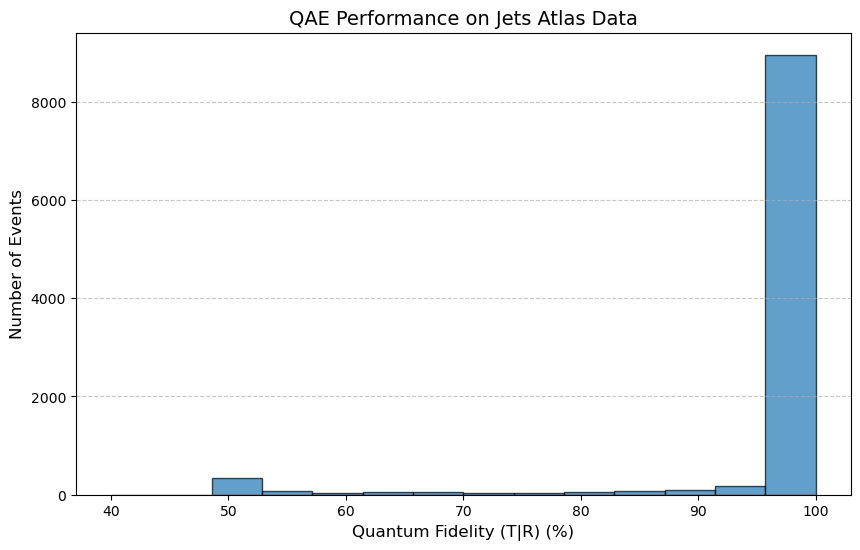

In [85]:
# --- Generación del Diagrama ---
plt.figure(figsize=(10, 6))
plt.hist(event_fidelities, bins=np.linspace(40, 100, 15), edgecolor='black', alpha=0.7)
plt.xlabel("Quantum Fidelity (T|R) (%)", fontsize=12)
plt.ylabel("Number of Events", fontsize=12)
plt.title("QAE Performance on Jets Atlas Data", fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.savefig("qae_fidelity_distribution.png", dpi=300, bbox_inches='tight')
plt.show()

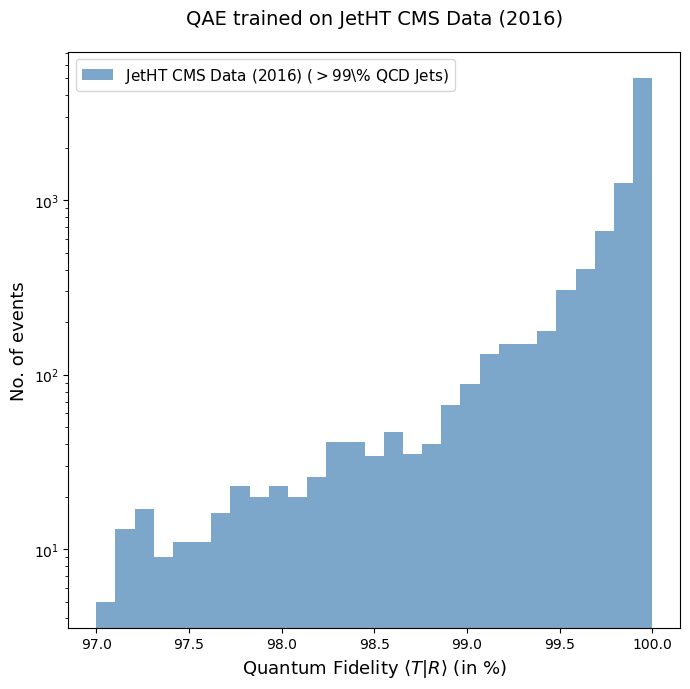

In [86]:
bins = np.linspace(97, 100, 30)

plt.figure(figsize=(7, 7))
plt.hist(event_fidelities, bins=bins, histtype='stepfilled',
         color='steelblue', alpha=0.7, label=r'JetHT CMS Data (2016) ($>$99\% QCD Jets)')
plt.yscale('log')
plt.xlabel(r'Quantum Fidelity $\langle T|R \rangle$ (in %)', fontsize=13)
plt.ylabel(r'No. of events', fontsize=13)
plt.legend(loc='upper left', fontsize=11)
plt.title(r'QAE trained on JetHT CMS Data (2016)', fontsize=14, pad=20)

# Ajuste de márgenes y guardado
plt.tight_layout()
plt.savefig("qae_fidelity_distribution_matched.png", dpi=300, bbox_inches='tight')
plt.show()

# Hora de la validación

In [87]:
event_fidelities_val = []

for jet in X_val:
    # Verificar que haya suficientes constituyentes
    if len(jet['constituents']) < num_particles:
        continue
    _, fidelity = cost_function_with_fidelity(jet, w, theta_i, phi_i, w_i, num_layers)
    event_fidelities_val.append(fidelity * 100) 

In [138]:
print(np.mean(event_fidelities_val))

99.27328097231313


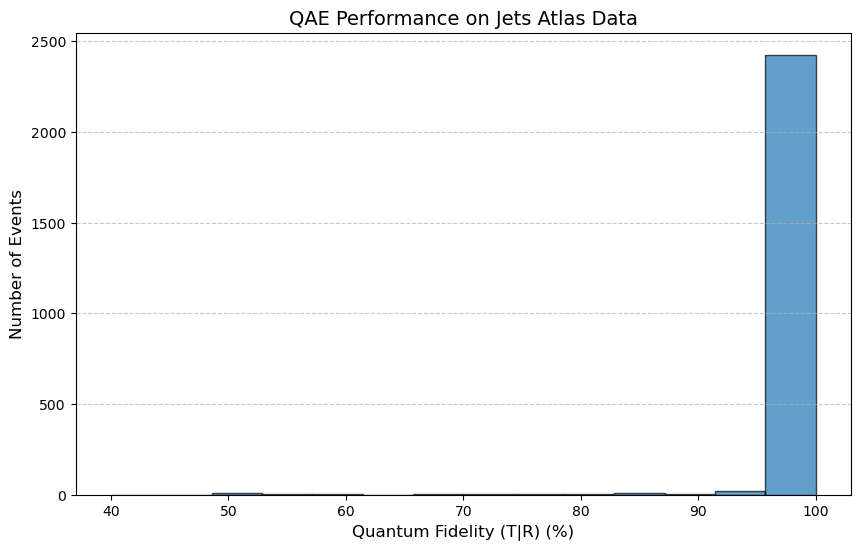

In [88]:
# --- Generación del Diagrama ---
plt.figure(figsize=(10, 6))
plt.hist(event_fidelities_val, bins=np.linspace(40, 100, 15), edgecolor='black', alpha=0.7)
plt.xlabel("Quantum Fidelity (T|R) (%)", fontsize=12)
plt.ylabel("Number of Events", fontsize=12)
plt.title("QAE Performance on Jets Atlas Data", fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.savefig("qae_fidelity_distribution.png", dpi=300, bbox_inches='tight')
plt.show()

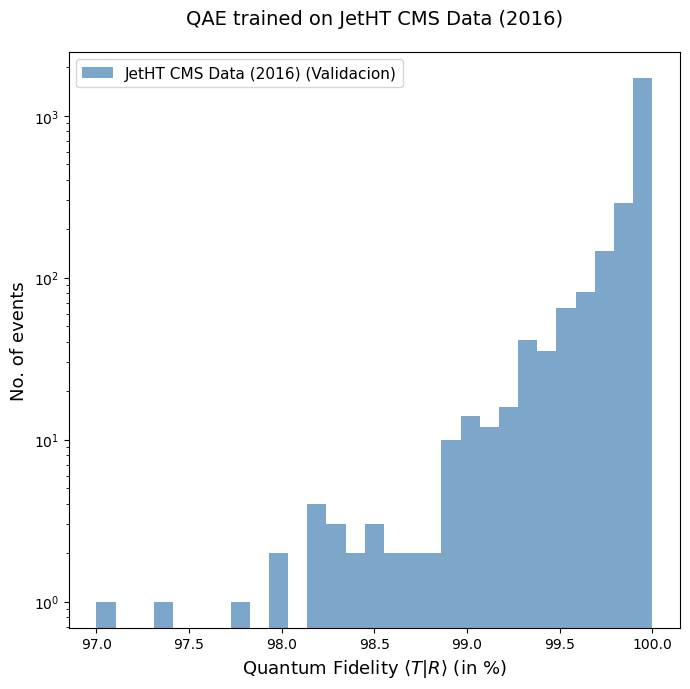

In [75]:
bins = np.linspace(97, 100, 30)

plt.figure(figsize=(7, 7))
plt.hist(event_fidelities_val, bins=bins, histtype='stepfilled',
         color='steelblue', alpha=0.7, label=r'JetHT CMS Data (2016) (Validacion)')
plt.yscale('log')
plt.xlabel(r'Quantum Fidelity $\langle T|R \rangle$ (in %)', fontsize=13)
plt.ylabel(r'No. of events', fontsize=13)
plt.legend(loc='upper left', fontsize=11)
plt.title(r'QAE trained on JetHT CMS Data (2016)', fontsize=14, pad=20)

# Ajuste de márgenes y guardado
plt.tight_layout()
plt.savefig("qae_fidelity_distribution_validation.png", dpi=300, bbox_inches='tight')
plt.show()

# Proceso de inferencia

In [89]:
from sklearn.metrics import roc_auc_score

event_fidelities_back = []
event_fidelities_HToBB = []
event_fidelities_WToQQ = []
event_fidelities_TTBar = []

fidelidades = []
etiquetas = []


for jet in X_inf:
    if len(jet['constituents']) < num_particles:
        continue
    _, fidelity = cost_function_with_fidelity(jet, w, theta_i, phi_i, w_i, num_layers)
    event_fidelities_back.append(fidelity * 100) 
    fidelidades.append(fidelity)
    etiquetas.append(0)

print("Terminada prueba de validación")


for jet in datos_HToBB:
    if len(jet['constituents']) < num_particles:
        continue
    _, fidelity = cost_function_with_fidelity(jet, w, theta_i, phi_i, w_i, num_layers)
    event_fidelities_HToBB.append(fidelity * 100) 
    fidelidades.append(fidelity)
    etiquetas.append(1)

print("Terminada prueba con HToBB")

for jet in datos_TTBar:
    if len(jet['constituents']) < num_particles:
        continue
    _, fidelity = cost_function_with_fidelity(jet, w, theta_i, phi_i, w_i, num_layers)
    event_fidelities_TTBar.append(fidelity * 100) 
    fidelidades.append(fidelity)
    etiquetas.append(1)

print("Terminada prueba con TTBar")

for jet in datos_WToqq:
    if len(jet['constituents']) < num_particles:
        continue
    _, fidelity = cost_function_with_fidelity(jet, w, theta_i, phi_i, w_i, num_layers)
    event_fidelities_WToQQ.append(fidelity * 100) 
    fidelidades.append(fidelity)
    etiquetas.append(1)

print("Terminada prueba con WToqq")

Terminada prueba de validación
Terminada prueba con HToBB
Terminada prueba con TTBar
Terminada prueba con WToqq


In [139]:
print(np.mean(event_fidelities_back))

99.23930718083923


In [ ]:

bins = np.linspace(40, 100, 20)

plt.hist(event_fidelities_back, bins=np.linspace(40, 100, 20), alpha=0.7, label='Trained data',)

# 2. Exotic (solo bordes, sin relleno)
plt.hist(event_fidelities_HToBB, 
         bins=bins, 
         edgecolor='red', 
         facecolor='none',  
         linewidth=1.5,     
         linestyle='--',    
         label='H --> BB',
         histtype='step',  
         stacked=True)

plt.hist(event_fidelities_TTBar, 
         bins=bins, 
         edgecolor='green', 
         facecolor='none',  
         linewidth=1.5,     
         linestyle=':',    
         label='t --> bqq',
         histtype='step',  
         stacked=True)

plt.hist(event_fidelities_WToQQ, 
         bins=bins, 
         edgecolor='green', 
         facecolor='none',  
         linewidth=1.5,     
         linestyle=':',    
         label='W --> QQ',
         histtype='step',  
         stacked=True)

# Personalización
plt.xlabel("Quantum Fidelity (T|R) (%)", fontsize=12)
plt.ylabel("Number of Events", fontsize=12)
plt.title("Trained vs Tested Results", fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(fontsize=12)
plt.show() 

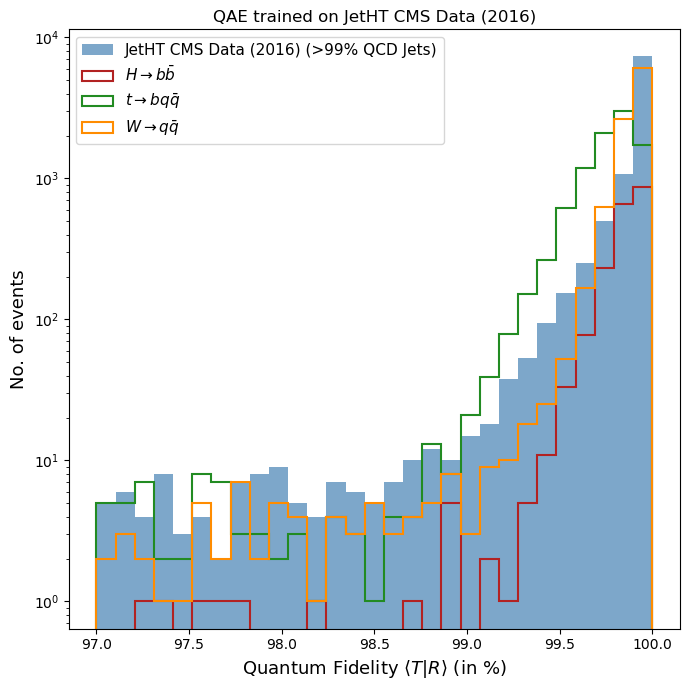

In [127]:
plt.figure(figsize=(7, 7))

bins = np.linspace(97, 100, 30)

# --- Background: relleno azul ---
plt.hist(event_fidelities_back, 
         bins=bins, 
         histtype='stepfilled', 
         color='steelblue', 
         alpha=0.7, 
         label=r'JetHT CMS Data (2016) (>99% QCD Jets)')

# --- H → bb : línea roja discontinua ---
plt.hist(event_fidelities_HToBB, 
         bins=bins, 
         histtype='step', 
         color='firebrick', 
         linewidth=1.5, 
         linestyle='-', 
         label=r'$H \rightarrow b\bar{b}$')

# --- t → bqq : línea verde punteada ---
plt.hist(event_fidelities_TTBar, 
         bins=bins, 
         histtype='step', 
         color='forestgreen', 
         linewidth=1.5, 
         linestyle='-', 
         label=r'$t \rightarrow bq\bar{q}$')

# --- W → qq : línea naranja punteada ---
plt.hist(event_fidelities_WToQQ, 
         bins=bins, 
         histtype='step', 
         color='darkorange', 
         linewidth=1.5, 
         linestyle='-', 
         label=r'$W \rightarrow q\bar{q}$')


plt.yscale('log')
plt.xlabel(r'Quantum Fidelity $\langle T|R \rangle$ (in %)', fontsize=13)
plt.ylabel(r'No. of events', fontsize=13)
plt.title(r'QAE trained on JetHT CMS Data (2016)', fontsize=12, pad=5)
plt.legend(loc='upper left', fontsize=11)


plt.tight_layout()
plt.savefig("qae_fidelity_distribution_final.png", dpi=300, bbox_inches='tight')
plt.show()

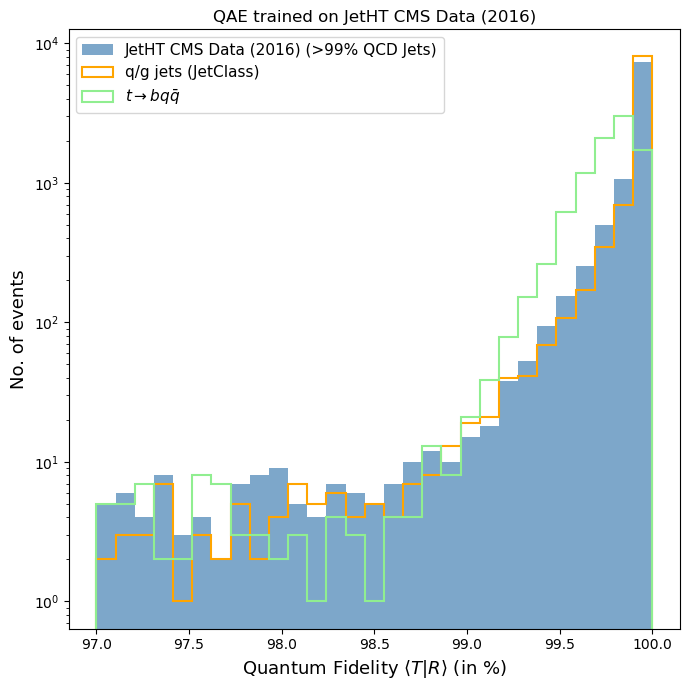

In [117]:
plt.figure(figsize=(7, 7))
bins = np.linspace(97, 100, 30)

# --- Background: relleno azul ---
plt.hist(event_fidelities_back, 
         bins=bins, 
         histtype='stepfilled', 
         color='steelblue', 
         alpha=0.7, 
         label=r'JetHT CMS Data (2016) (>99% QCD Jets)')


plt.hist(event_fidelities_QCD, 
         bins=bins, 
         histtype='step', 
         color='orange', 
         linewidth=1.5, 
         linestyle='-', 
         label=r'q/g jets (JetClass)')


plt.hist(event_fidelities_TTBar, 
         bins=bins, 
         histtype='step', 
         color='lightgreen', 
         linewidth=1.5, 
         linestyle='-', 
         label=r'$t \rightarrow bq\bar{q}$')

plt.yscale('log')
plt.xlabel(r'Quantum Fidelity $\langle T|R \rangle$ (in %)', fontsize=13)
plt.ylabel(r'No. of events', fontsize=13)
plt.title(r'QAE trained on JetHT CMS Data (2016)', fontsize=12, pad=5)
plt.legend(loc='upper left', fontsize=11)

# Ajuste de márgenes y guardado
plt.tight_layout()
plt.savefig("qae_fidelity_distribution_final.png", dpi=300, bbox_inches='tight')
plt.show()

In [118]:
 avg_fidelity_qcd = np.mean(event_fidelities_QCD) 
print(avg_fidelity_qcd)

99.5142751453503


In [142]:
 avg_fidelity_qcd = np.mean(event_fidelities_back) 
print(avg_fidelity_qcd)

avg_fidelity_qcd = np.mean(event_fidelities_WToQQ) 
print(avg_fidelity_qcd)

avg_fidelity_qcd = np.mean(event_fidelities_HToBB) 
print(avg_fidelity_qcd)

avg_fidelity_qcd = np.mean(event_fidelities_TTBar) 
print(avg_fidelity_qcd)

99.04088348009361
98.57099900150962
98.13572012341908


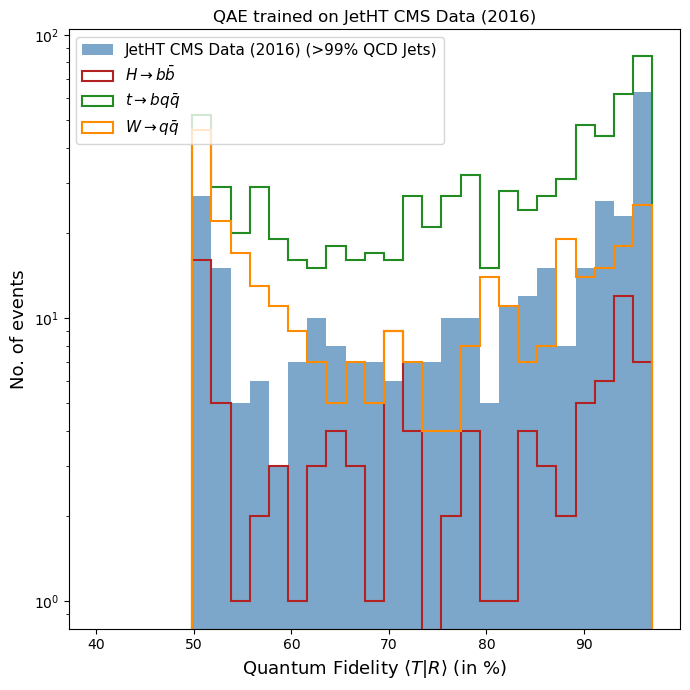

In [131]:
plt.figure(figsize=(7, 7))

# Definir bins (de 97 a 100, como en la referencia)
bins = np.linspace(40, 97, 30)

# --- Background: relleno azul ---
plt.hist(event_fidelities_back, 
         bins=bins, 
         histtype='stepfilled', 
         color='steelblue', 
         alpha=0.7, 
         label=r'JetHT CMS Data (2016) (>99% QCD Jets)')

# --- H → bb : línea roja discontinua ---
plt.hist(event_fidelities_HToBB, 
         bins=bins, 
         histtype='step', 
         color='firebrick', 
         linewidth=1.5, 
         linestyle='-', 
         label=r'$H \rightarrow b\bar{b}$')

# --- t → bqq : línea verde punteada ---
plt.hist(event_fidelities_TTBar, 
         bins=bins, 
         histtype='step', 
         color='forestgreen', 
         linewidth=1.5, 
         linestyle='-', 
         label=r'$t \rightarrow bq\bar{q}$')

# --- W → qq : línea naranja punteada ---
plt.hist(event_fidelities_WToQQ, 
         bins=bins, 
         histtype='step', 
         color='darkorange', 
         linewidth=1.5, 
         linestyle='-', 
         label=r'$W \rightarrow q\bar{q}$')

plt.yscale('log')
plt.xlabel(r'Quantum Fidelity $\langle T|R \rangle$ (in %)', fontsize=13)
plt.ylabel(r'No. of events', fontsize=13)
plt.title(r'QAE trained on JetHT CMS Data (2016)', fontsize=12, pad=5)
plt.legend(loc='upper left', fontsize=11)

plt.tight_layout()
plt.savefig("qae_fidelity_distribution_final_acotado.png", dpi=300, bbox_inches='tight')
plt.show()

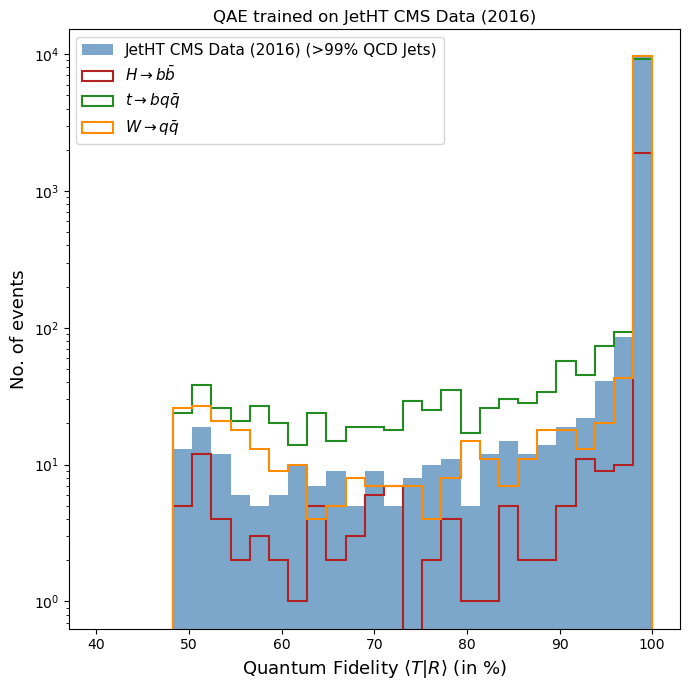

In [132]:
plt.figure(figsize=(7, 7))

# Definir bins (de 97 a 100, como en la referencia)
bins = np.linspace(40, 100, 30)

# --- Background: relleno azul ---
plt.hist(event_fidelities_back, 
         bins=bins, 
         histtype='stepfilled', 
         color='steelblue', 
         alpha=0.7, 
         label=r'JetHT CMS Data (2016) (>99% QCD Jets)')

# --- H → bb : línea roja discontinua ---
plt.hist(event_fidelities_HToBB, 
         bins=bins, 
         histtype='step', 
         color='firebrick', 
         linewidth=1.5, 
         linestyle='-', 
         label=r'$H \rightarrow b\bar{b}$')

# --- t → bqq : línea verde punteada ---
plt.hist(event_fidelities_TTBar, 
         bins=bins, 
         histtype='step', 
         color='forestgreen', 
         linewidth=1.5, 
         linestyle='-', 
         label=r'$t \rightarrow bq\bar{q}$')

# --- W → qq : línea naranja punteada ---
plt.hist(event_fidelities_WToQQ, 
         bins=bins, 
         histtype='step', 
         color='darkorange', 
         linewidth=1.5, 
         linestyle='-', 
         label=r'$W \rightarrow q\bar{q}$')

plt.yscale('log')
plt.xlabel(r'Quantum Fidelity $\langle T|R \rangle$ (in %)', fontsize=13)
plt.ylabel(r'No. of events', fontsize=13)
plt.title(r'QAE trained on JetHT CMS Data (2016)', fontsize=12, pad=5)
plt.legend(loc='upper left', fontsize=11)
plt.tight_layout()
plt.savefig("qae_fidelity_distribution_final_acotado.png", dpi=300, bbox_inches='tight')
plt.show()

AUC (QCD vs H→bb): 0.7294
AUC (QCD vs t→bqq): 0.8286
AUC (QCD vs W→qq): 0.6643
AUC (QCD vs W→qq): 0.4063


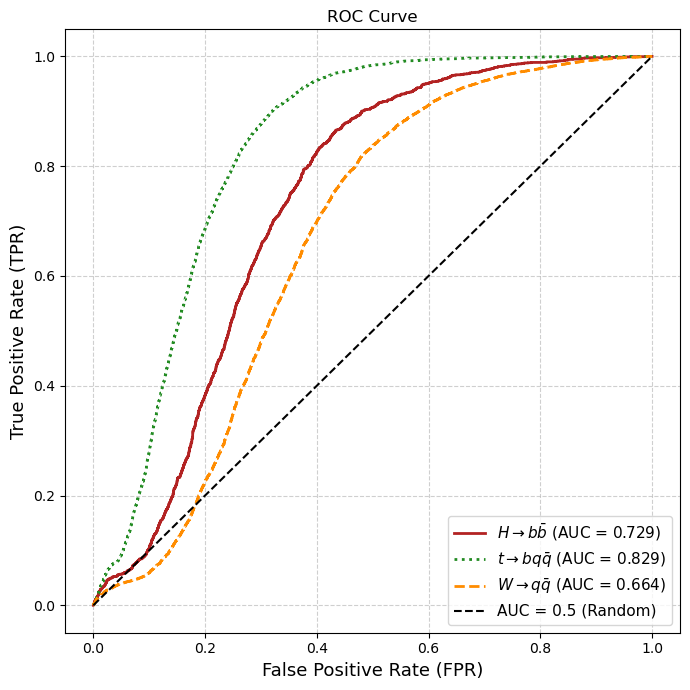

In [136]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import numpy as np

# --- Anomaly scores (1 - Fidelity) ---
anomaly_scores_back = 1 - np.array(event_fidelities_back)
anomaly_scores_HToBB = 1 - np.array(event_fidelities_HToBB)
anomaly_scores_TTBar = 1 - np.array(event_fidelities_TTBar)
anomaly_scores_WToQQ = 1 - np.array(event_fidelities_WToQQ)
anomaly_scores_QCD = 1 - np.array(event_fidelities_QCD)


# --- Calcular AUC ---
auc_HToBB = roc_auc_score(
    np.concatenate([np.zeros_like(anomaly_scores_back), np.ones_like(anomaly_scores_HToBB)]),
    np.concatenate([anomaly_scores_back, anomaly_scores_HToBB])
)

auc_TTBar = roc_auc_score(
    np.concatenate([np.zeros_like(anomaly_scores_back), np.ones_like(anomaly_scores_TTBar)]),
    np.concatenate([anomaly_scores_back, anomaly_scores_TTBar])
)

auc_WToQQ = roc_auc_score(
    np.concatenate([np.zeros_like(anomaly_scores_back), np.ones_like(anomaly_scores_WToQQ)]),
    np.concatenate([anomaly_scores_back, anomaly_scores_WToQQ])
)

auc_QCD = roc_auc_score(
    np.concatenate([np.zeros_like(anomaly_scores_back), np.ones_like(anomaly_scores_QCD)]),
    np.concatenate([anomaly_scores_back, anomaly_scores_QCD])
)

print(f"AUC (QCD vs H→bb): {auc_HToBB:.4f}")
print(f"AUC (QCD vs t→bqq): {auc_TTBar:.4f}")
print(f"AUC (QCD vs W→qq): {auc_WToQQ:.4f}")
print(f"AUC (QCD vs W→qq): {auc_QCD:.4f}")

# --- Graficar curvas ROC ---
plt.figure(figsize=(7, 7))

# H→bb
fpr_HToBB, tpr_HToBB, _ = roc_curve(
    np.concatenate([np.zeros_like(anomaly_scores_back), np.ones_like(anomaly_scores_HToBB)]),
    np.concatenate([anomaly_scores_back, anomaly_scores_HToBB])
)
plt.plot(fpr_HToBB, tpr_HToBB, color='firebrick', linewidth=2,
         label=rf'$H \rightarrow b\bar{{b}}$ (AUC = {auc_HToBB:.3f})')

# t→bqq
fpr_TTBar, tpr_TTBar, _ = roc_curve(
    np.concatenate([np.zeros_like(anomaly_scores_back), np.ones_like(anomaly_scores_TTBar)]),
    np.concatenate([anomaly_scores_back, anomaly_scores_TTBar])
)
plt.plot(fpr_TTBar, tpr_TTBar, color='forestgreen', linewidth=2, linestyle=':',
         label=rf'$t \rightarrow bq\bar{{q}}$ (AUC = {auc_TTBar:.3f})')

# W→qq
fpr_WToQQ, tpr_WToQQ, _ = roc_curve(
    np.concatenate([np.zeros_like(anomaly_scores_back), np.ones_like(anomaly_scores_WToQQ)]),
    np.concatenate([anomaly_scores_back, anomaly_scores_WToQQ])
)

fpr_WToQQ, tpr_WToQQ, _ = roc_curve(
    np.concatenate([np.zeros_like(anomaly_scores_back), np.ones_like(anomaly_scores_WToQQ)]),
    np.concatenate([anomaly_scores_back, anomaly_scores_WToQQ])
)

plt.plot(fpr_WToQQ, tpr_WToQQ, color='darkorange', linewidth=2, linestyle='--',
         label=rf'$W \rightarrow q\bar{{q}}$ (AUC = {auc_WToQQ:.3f})')

plt.plot([0, 1], [0, 1], 'k--', label=r'AUC = 0.5 (Random)')
plt.xlabel(r'False Positive Rate (FPR)', fontsize=13)
plt.ylabel(r'True Positive Rate (TPR)', fontsize=13)
plt.title(r'ROC Curve', fontsize=12, pad=5)
plt.legend(loc='lower right', fontsize=11)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.savefig("qae_roc_curve_final.png", dpi=300, bbox_inches='tight')
plt.show()


⟨1-Fidelity⟩ QCD: 99.2393
AUC (QCD vs H→bb): 0.7294
AUC (QCD vs t→bqq): 0.8286
AUC (QCD vs W→qq): 0.6643


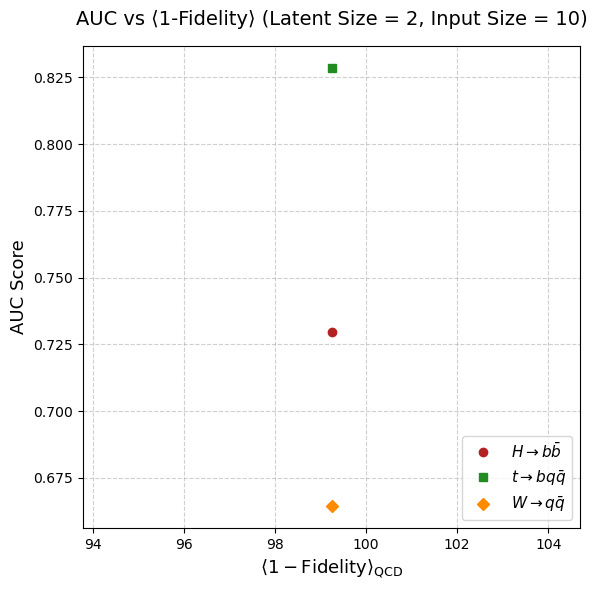

In [143]:
# --- Datos fidelities ya calculados en tu entrenamiento ---
anomaly_scores_back = 1 - np.array(event_fidelities_back)
anomaly_scores_HToBB = 1 - np.array(event_fidelities_HToBB)
anomaly_scores_TTBar = 1 - np.array(event_fidelities_TTBar)
anomaly_scores_WToQQ = 1 - np.array(event_fidelities_WToQQ)

# --- Calcular promedio de (1-Fidelity) de QCD ---
mean_1minus_fidelity_QCD = 1 - np.mean(anomaly_scores_back)

# --- Calcular AUCs ---
auc_HToBB = roc_auc_score(
    np.concatenate([np.zeros_like(anomaly_scores_back), np.ones_like(anomaly_scores_HToBB)]),
    np.concatenate([anomaly_scores_back, anomaly_scores_HToBB])
)

auc_TTBar = roc_auc_score(
    np.concatenate([np.zeros_like(anomaly_scores_back), np.ones_like(anomaly_scores_TTBar)]),
    np.concatenate([anomaly_scores_back, anomaly_scores_TTBar])
)

auc_WToQQ = roc_auc_score(
    np.concatenate([np.zeros_like(anomaly_scores_back), np.ones_like(anomaly_scores_WToQQ)]),
    np.concatenate([anomaly_scores_back, anomaly_scores_WToQQ])
)

print(f"⟨1-Fidelity⟩ QCD: {mean_1minus_fidelity_QCD:.4f}")
print(f"AUC (QCD vs H→bb): {auc_HToBB:.4f}")
print(f"AUC (QCD vs t→bqq): {auc_TTBar:.4f}")
print(f"AUC (QCD vs W→qq): {auc_WToQQ:.4f}")

# --- Graficar ---
plt.figure(figsize=(6,6))

# H→bb
plt.plot(mean_1minus_fidelity_QCD, auc_HToBB, 'o', color='firebrick', label=r'$H \rightarrow b\bar{b}$')

# t→bqq
plt.plot(mean_1minus_fidelity_QCD, auc_TTBar, 's', color='forestgreen', label=r'$t \rightarrow bq\bar{q}$')

# W→qq
plt.plot(mean_1minus_fidelity_QCD, auc_WToQQ, 'D', color='darkorange', label=r'$W \rightarrow q\bar{q}$')

# Ejes y estilos
plt.xlabel(r'$\langle 1 - \mathrm{Fidelity} \rangle_\mathrm{QCD}$', fontsize=13)
plt.ylabel('AUC Score', fontsize=13)
plt.title('AUC vs ⟨1-Fidelity⟩ (Latent Size = 2, Input Size = 10)', fontsize=14, pad=15)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(fontsize=11, loc='lower right')

plt.tight_layout()
plt.savefig("AUC_vs_Fidelity_Latent2_Input10.png", dpi=300)
plt.show()

## **Prueba con 4 qubits para comparar con el caso de 4 qutrits**

In [ ]:
# --- Parámetros del circuito ---
num_particles = 4
num_latent = 1
num_ref = num_particles - num_latent
num_trash = num_ref
wires = list(range(num_particles + num_ref + 1))  # +1 ancilla
ancilla = wires[-1]
dev = qml.device("default.qubit", wires=wires)

latent_wire = 0
trash_wires = wires[1:num_particles]
ref_wires = wires[num_particles:-1]

import torch
import numpy as np

# --- Inicialización de parámetros ---
w = torch.tensor(1.0, requires_grad=True)
num_layers = 1
theta_i = (torch.rand(num_layers, num_particles) * 2 * torch.pi).requires_grad_(True)
phi_i   = (torch.rand(num_layers, num_particles) * 2 * torch.pi).requires_grad_(True)
w_i     = (torch.rand(num_layers, num_particles) * 2 * torch.pi).requires_grad_(True)

optimizer = torch.optim.Adam(
    [w, theta_i, phi_i, w_i],
    lr=5e-3,              
    betas=(0.5, 0.999),
    eps=1e-08,
    weight_decay=0.0,    
    amsgrad=True          
)

num_epochs = 1
all_fidelities = []
event_fidelities = []

# Asegúrate de tener tus datos cargados como:
# X_train = cargar_datos_json("runG_batch0_reducido.json")
inicio = time.time()
# --- Entrenamiento ---
for epoch in range(num_epochs):
    total_loss = 0.0
    epoch_fidelities = []

    for jet in X_train:
        # Verificar que haya suficientes constituyentes
        if len(jet['constituents']) < num_particles:
            continue

        loss, fidelity = cost_function_with_fidelity(jet, w, theta_i, phi_i, w_i, num_layers)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        epoch_fidelities.append(fidelity)
        event_fidelities.append(fidelity * 100)  # en %

    avg_loss = total_loss / len(epoch_fidelities)
    avg_fidelity = np.mean(epoch_fidelities) * 100
    all_fidelities.append(avg_fidelity)

    print(f"Epoch {epoch+1}, Loss: {1 + avg_loss:.4f}, Avg Fidelity: {avg_fidelity:.2f}%")

end = time.time()



In [147]:
tiempo_entrenamiento = (end - inicio)/ 60
print("Tiempo transcurrido: ", tiempo_entrenamiento)

Tiempo transcurrido:  4.154445354143778


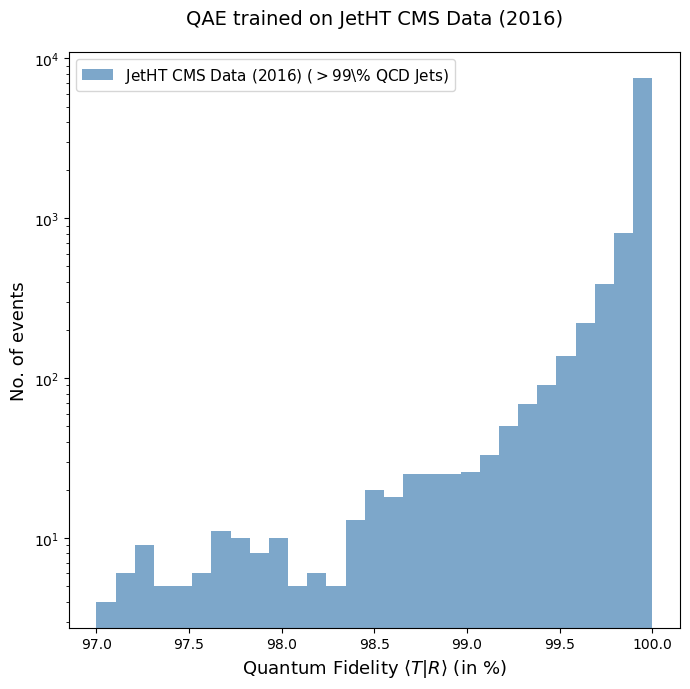

In [65]:
# --- Generación del Diagrama ---
bins = np.linspace(97, 100, 30)

plt.figure(figsize=(7, 7))
plt.hist(event_fidelities, bins=bins, histtype='stepfilled',
         color='steelblue', alpha=0.7, label=r'JetHT CMS Data (2016) (>99% QCD Jets)')
plt.yscale('log')
plt.xlabel(r'Quantum Fidelity $\langle T|R \rangle$ (in %)', fontsize=13)
plt.ylabel(r'No. of events', fontsize=13)
plt.legend(loc='upper left', fontsize=11)
plt.title(r'QAE trained on JetHT CMS Data (2016)', fontsize=14, pad=20)

# Ajuste de márgenes y guardado
plt.tight_layout()
plt.savefig("qae_fidelity_distribution_matched_4Q.png", dpi=300, bbox_inches='tight')
plt.show()

In [148]:
from sklearn.metrics import roc_auc_score

event_fidelities_back = []
event_fidelities_HToBB = []
event_fidelities_WToQQ = []
event_fidelities_TTBar = []
fidelidades = []
etiquetas = []

inicio = time.time()
for jet in X_inf:
    if len(jet['constituents']) < num_particles:
        continue
    _, fidelity = cost_function_with_fidelity(jet, w, theta_i, phi_i, w_i, num_layers)
    event_fidelities_back.append(fidelity * 100) 
    fidelidades.append(fidelity)
    etiquetas.append(0)

print("Terminada prueba de validación")
end = time.time()
tiempo_test = (end - inicio)/ 60
print("Tiempo transcurrido: ", tiempo_test)

inicio = time.time()
for jet in datos_HToBB:
    if len(jet['constituents']) < num_particles:
        continue
    _, fidelity = cost_function_with_fidelity(jet, w, theta_i, phi_i, w_i, num_layers)
    event_fidelities_HToBB.append(fidelity * 100) 
    fidelidades.append(fidelity)
    etiquetas.append(1)

print("Terminada prueba con HToBB")

for jet in datos_TTBar:
    if len(jet['constituents']) < num_particles:
        continue
    _, fidelity = cost_function_with_fidelity(jet, w, theta_i, phi_i, w_i, num_layers)
    event_fidelities_TTBar.append(fidelity * 100) 
    fidelidades.append(fidelity)
    etiquetas.append(1)

print("Terminada prueba con TTBar")

for jet in datos_WToqq:
    if len(jet['constituents']) < num_particles:
        continue
    _, fidelity = cost_function_with_fidelity(jet, w, theta_i, phi_i, w_i, num_layers)
    event_fidelities_WToQQ.append(fidelity * 100) 
    fidelidades.append(fidelity)
    etiquetas.append(1)

print("Terminada prueba con WToqq")
end = time.time()
tiempo_inf = (end - inicio)/ 60
print("Tiempo transcurrido: ", tiempo_inf)

Terminada prueba de validación
Tiempo transcurrido:  2.5787497639656065
Terminada prueba con HToBB
Terminada prueba con TTBar
Terminada prueba con WToqq
Tiempo transcurrido:  5.644254187742869


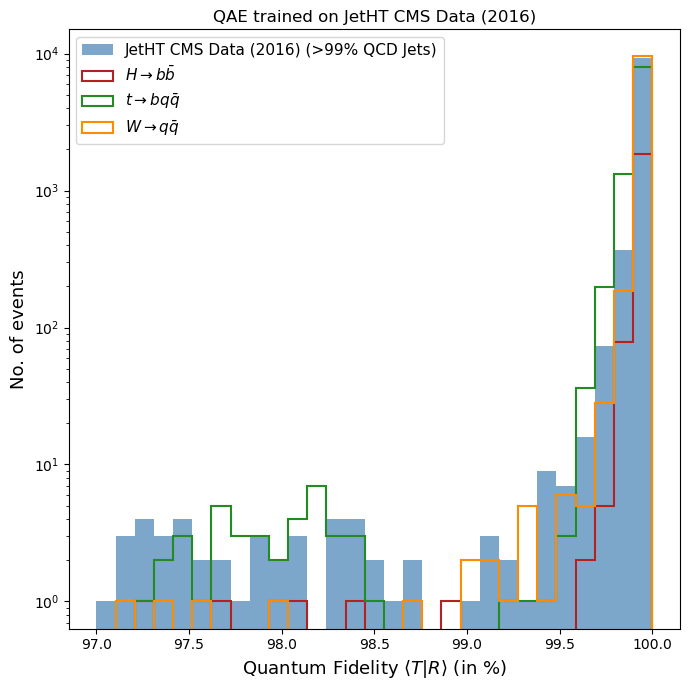

In [155]:
plt.figure(figsize=(7, 7))

# Definir bins (de 97 a 100, como en la referencia)
bins = np.linspace(97, 100, 30)

# --- Background: relleno azul ---
plt.hist(event_fidelities_back, 
         bins=bins, 
         histtype='stepfilled', 
         color='steelblue', 
         alpha=0.7, 
         label=r'JetHT CMS Data (2016) (>99% QCD Jets)')

# --- H → bb : línea roja discontinua ---
plt.hist(event_fidelities_HToBB, 
         bins=bins, 
         histtype='step', 
         color='firebrick', 
         linewidth=1.5, 
         linestyle='-', 
         label=r'$H \rightarrow b\bar{b}$')

# --- t → bqq : línea verde punteada ---
plt.hist(event_fidelities_TTBar, 
         bins=bins, 
         histtype='step', 
         color='forestgreen', 
         linewidth=1.5, 
         linestyle='-', 
         label=r'$t \rightarrow bq\bar{q}$')

# --- W → qq : línea naranja punteada ---
plt.hist(event_fidelities_WToQQ, 
         bins=bins, 
         histtype='step', 
         color='darkorange', 
         linewidth=1.5, 
         linestyle='-', 
         label=r'$W \rightarrow q\bar{q}$')

# --- Personalización ejes y leyenda ---
plt.yscale('log')
plt.xlabel(r'Quantum Fidelity $\langle T|R \rangle$ (in %)', fontsize=13)
plt.ylabel(r'No. of events', fontsize=13)
plt.title(r'QAE trained on JetHT CMS Data (2016)', fontsize=12, pad=5)
plt.legend(loc='upper left', fontsize=11)

# Ajuste de márgenes y guardado
plt.tight_layout()
plt.savefig("qae_fidelity_distribution_final_4Q.png", dpi=300, bbox_inches='tight')
plt.show()

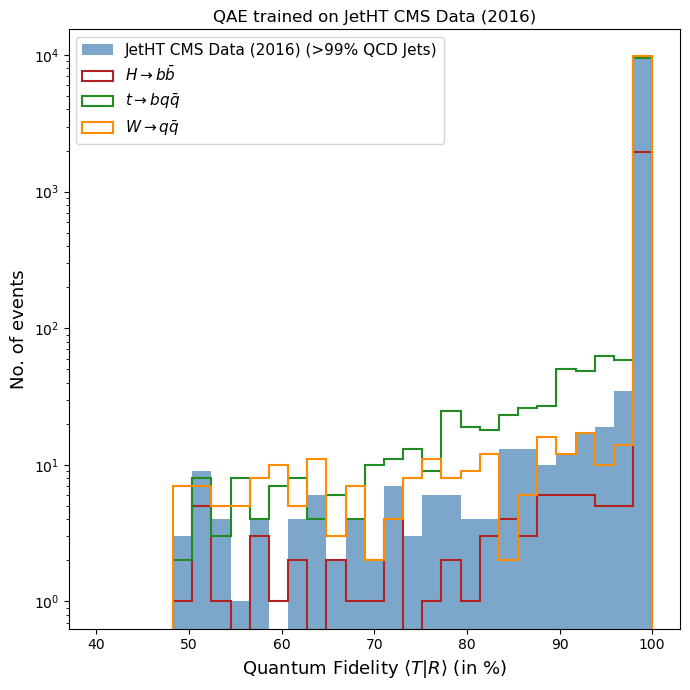

In [156]:
plt.figure(figsize=(7, 7))

# Definir bins (de 97 a 100, como en la referencia)
bins = np.linspace(40, 100, 30)

# --- Background: relleno azul ---
plt.hist(event_fidelities_back, 
         bins=bins, 
         histtype='stepfilled', 
         color='steelblue', 
         alpha=0.7, 
         label=r'JetHT CMS Data (2016) (>99% QCD Jets)')

# --- H → bb : línea roja discontinua ---
plt.hist(event_fidelities_HToBB, 
         bins=bins, 
         histtype='step', 
         color='firebrick', 
         linewidth=1.5, 
         linestyle='-', 
         label=r'$H \rightarrow b\bar{b}$')

# --- t → bqq : línea verde punteada ---
plt.hist(event_fidelities_TTBar, 
         bins=bins, 
         histtype='step', 
         color='forestgreen', 
         linewidth=1.5, 
         linestyle='-', 
         label=r'$t \rightarrow bq\bar{q}$')

# --- W → qq : línea naranja punteada ---
plt.hist(event_fidelities_WToQQ, 
         bins=bins, 
         histtype='step', 
         color='darkorange', 
         linewidth=1.5, 
         linestyle='-', 
         label=r'$W \rightarrow q\bar{q}$')


plt.yscale('log')
plt.xlabel(r'Quantum Fidelity $\langle T|R \rangle$ (in %)', fontsize=13)
plt.ylabel(r'No. of events', fontsize=13)
plt.title(r'QAE trained on JetHT CMS Data (2016)', fontsize=12, pad=5)
plt.legend(loc='upper left', fontsize=11)
plt.tight_layout()
plt.savefig("qae_fidelity_distribution_final_acotado_4Q.png", dpi=300, bbox_inches='tight')
plt.show()

AUC (QCD vs H→bb): 0.7362
AUC (QCD vs t→bqq): 0.8219
AUC (QCD vs W→qq): 0.6844


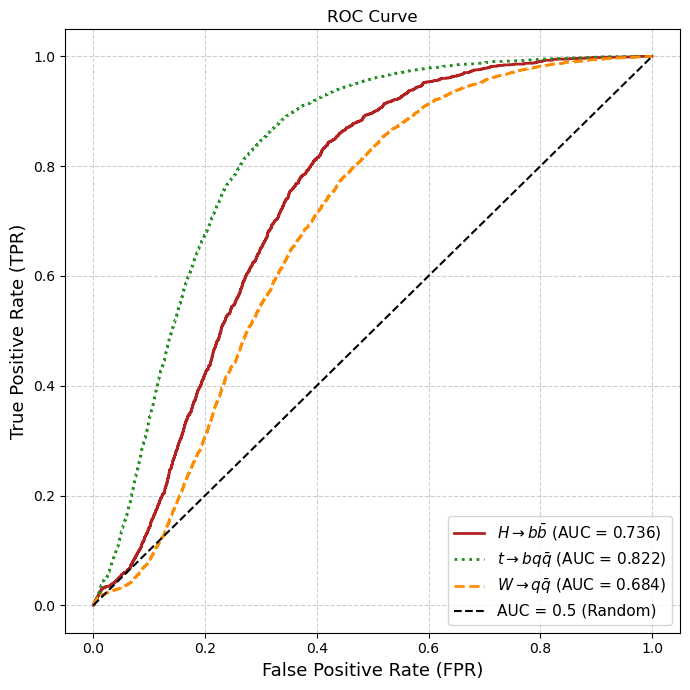

In [157]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import numpy as np

# --- Anomaly scores (1 - Fidelity) ---
anomaly_scores_back = 1 - np.array(event_fidelities_back)
anomaly_scores_HToBB = 1 - np.array(event_fidelities_HToBB)
anomaly_scores_TTBar = 1 - np.array(event_fidelities_TTBar)
anomaly_scores_WToQQ = 1 - np.array(event_fidelities_WToQQ)

# --- Calcular AUC ---
auc_HToBB = roc_auc_score(
    np.concatenate([np.zeros_like(anomaly_scores_back), np.ones_like(anomaly_scores_HToBB)]),
    np.concatenate([anomaly_scores_back, anomaly_scores_HToBB])
)

auc_TTBar = roc_auc_score(
    np.concatenate([np.zeros_like(anomaly_scores_back), np.ones_like(anomaly_scores_TTBar)]),
    np.concatenate([anomaly_scores_back, anomaly_scores_TTBar])
)

auc_WToQQ = roc_auc_score(
    np.concatenate([np.zeros_like(anomaly_scores_back), np.ones_like(anomaly_scores_WToQQ)]),
    np.concatenate([anomaly_scores_back, anomaly_scores_WToQQ])
)

print(f"AUC (QCD vs H→bb): {auc_HToBB:.4f}")
print(f"AUC (QCD vs t→bqq): {auc_TTBar:.4f}")
print(f"AUC (QCD vs W→qq): {auc_WToQQ:.4f}")

# --- Graficar curvas ROC ---
plt.figure(figsize=(7, 7))

# H→bb
fpr_HToBB, tpr_HToBB, _ = roc_curve(
    np.concatenate([np.zeros_like(anomaly_scores_back), np.ones_like(anomaly_scores_HToBB)]),
    np.concatenate([anomaly_scores_back, anomaly_scores_HToBB])
)
plt.plot(fpr_HToBB, tpr_HToBB, color='firebrick', linewidth=2,
         label=rf'$H \rightarrow b\bar{{b}}$ (AUC = {auc_HToBB:.3f})')

# t→bqq
fpr_TTBar, tpr_TTBar, _ = roc_curve(
    np.concatenate([np.zeros_like(anomaly_scores_back), np.ones_like(anomaly_scores_TTBar)]),
    np.concatenate([anomaly_scores_back, anomaly_scores_TTBar])
)
plt.plot(fpr_TTBar, tpr_TTBar, color='forestgreen', linewidth=2, linestyle=':',
         label=rf'$t \rightarrow bq\bar{{q}}$ (AUC = {auc_TTBar:.3f})')

# W→qq
fpr_WToQQ, tpr_WToQQ, _ = roc_curve(
    np.concatenate([np.zeros_like(anomaly_scores_back), np.ones_like(anomaly_scores_WToQQ)]),
    np.concatenate([anomaly_scores_back, anomaly_scores_WToQQ])
)
plt.plot(fpr_WToQQ, tpr_WToQQ, color='darkorange', linewidth=2, linestyle='--',
         label=rf'$W \rightarrow q\bar{{q}}$ (AUC = {auc_WToQQ:.3f})')

# Línea aleatoria (AUC = 0.5)
plt.plot([0, 1], [0, 1], 'k--', label=r'AUC = 0.5 (Random)')

# --- Personalización ejes y leyenda ---
plt.xlabel(r'False Positive Rate (FPR)', fontsize=13)
plt.ylabel(r'True Positive Rate (TPR)', fontsize=13)
plt.title(r'ROC Curve', fontsize=12, pad=5)
plt.legend(loc='lower right', fontsize=11)
plt.grid(True, linestyle='--', alpha=0.6)

# Ajuste márgenes y guardado
plt.tight_layout()
plt.savefig("qae_roc_curve_final.png", dpi=300, bbox_inches='tight')
plt.show()


In [149]:
 avg_fidelity_qcd = np.mean(event_fidelities_back) 
print(avg_fidelity_qcd)

avg_fidelity_qcd = np.mean(event_fidelities_WToQQ) 
print(avg_fidelity_qcd)

avg_fidelity_qcd = np.mean(event_fidelities_HToBB) 
print(avg_fidelity_qcd)

avg_fidelity_qcd = np.mean(event_fidelities_TTBar) 
print(avg_fidelity_qcd)

99.65233709473226
99.50891366233314
99.3235114688843
99.2406612730489
